**Задание:** используя np.random научиться сэмплировать случайные точки из двумерного нормального распределения. В качестве параметров двух разных нормальных распределений взять mu_0=(-1, -1) и mu_1 = (1, 1), с единичными дисперсиями.

**Пояснение:** у нас есть 2 класса - 0 и 1. 0 (нули) подчиняются двумерному распределению с mu_0=(-1, -1) и дисперсией 1, а 1 (единицы) подчиняются двумерному распределению с mu_1 = (1, 1) и дисперсией 1. Это то, что мы будем предсказывать. 

Пример - сгенерим 500 нулей:

*rng = np.random.default_rng()*

*data_0 = np.concatenate([rng.normal((-1, -1), 1, (500, 2)), np.zeros((500, 1))], axis=1)*

То есть получается, что на выходе у нас каждую метку (0 или 1) будут характеризовать пара чисел из двумерного нормального распределения, и эту пару чисел (это одномерный массив) мы будем подавать в сетку.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Создаем два массива:

In [ ]:
rng = np.random.default_rng()
data_0 = np.concatenate([rng.normal((-1, -1), 1, (50, 2)), np.zeros((50, 1))], axis=1)

In [ ]:
rng = np.random.default_rng()
data_1 = np.concatenate([rng.normal((1, 1), 1, (50, 2)), np.ones((50, 1))], axis=1)

Получаем массив такой же размерности из случайно взятых элементов этих двух массивов:

In [ ]:
def random_mix(X, Y):
    c = np.concatenate((X, Y))
    np.random.shuffle(c)
    return c

In [ ]:
data = random_mix(data_0, data_1)
print(data)

[[ 1.34767594e+00 -2.28069497e+00  0.00000000e+00]
 [ 1.22669220e+00  2.31431347e+00  1.00000000e+00]
 [-4.89953319e-02  1.30737973e+00  1.00000000e+00]
 [ 9.01712979e-01 -6.26785356e-01  1.00000000e+00]
 [-1.07126978e-01  2.65173088e-01  1.00000000e+00]
 [-3.24459020e+00 -1.17718463e+00  0.00000000e+00]
 [ 3.47871780e-01 -9.51394585e-01  0.00000000e+00]
 [ 1.97499562e+00  2.83105940e-01  1.00000000e+00]
 [-1.00726621e+00 -2.33754138e+00  0.00000000e+00]
 [-9.18287377e-01 -1.95662202e+00  0.00000000e+00]
 [-9.81004701e-01 -1.13331986e+00  0.00000000e+00]
 [ 1.01743272e+00 -5.15593759e-01  1.00000000e+00]
 [ 1.58799992e+00 -1.16481525e+00  1.00000000e+00]
 [ 2.99481210e-01 -4.03655813e-01  0.00000000e+00]
 [-8.59261878e-01 -2.08972722e+00  0.00000000e+00]
 [-8.88412622e-01  4.01556507e-01  0.00000000e+00]
 [-1.20672722e+00 -2.78681701e+00  0.00000000e+00]
 [-1.58607599e+00 -6.64018218e-02  0.00000000e+00]
 [-4.96947798e-01 -3.80284331e-01  0.00000000e+00]
 [-8.52356522e-01  1.28522620e+

Разбваем полученный массив на два массива: первый с данными для обучения (Х), второй с метками классов (Т):

In [ ]:
X = data[:, [0, 1]]
print(X)

[[ 1.34767594e+00 -2.28069497e+00]
 [ 1.22669220e+00  2.31431347e+00]
 [-4.89953319e-02  1.30737973e+00]
 [ 9.01712979e-01 -6.26785356e-01]
 [-1.07126978e-01  2.65173088e-01]
 [-3.24459020e+00 -1.17718463e+00]
 [ 3.47871780e-01 -9.51394585e-01]
 [ 1.97499562e+00  2.83105940e-01]
 [-1.00726621e+00 -2.33754138e+00]
 [-9.18287377e-01 -1.95662202e+00]
 [-9.81004701e-01 -1.13331986e+00]
 [ 1.01743272e+00 -5.15593759e-01]
 [ 1.58799992e+00 -1.16481525e+00]
 [ 2.99481210e-01 -4.03655813e-01]
 [-8.59261878e-01 -2.08972722e+00]
 [-8.88412622e-01  4.01556507e-01]
 [-1.20672722e+00 -2.78681701e+00]
 [-1.58607599e+00 -6.64018218e-02]
 [-4.96947798e-01 -3.80284331e-01]
 [-8.52356522e-01  1.28522620e+00]
 [-2.19483204e+00  7.88265782e-01]
 [ 1.45712409e-01  1.21157345e+00]
 [-1.15301539e+00 -3.18309037e-01]
 [-3.77139445e-01 -2.26068024e+00]
 [ 1.69957158e+00  1.00602741e+00]
 [-1.17401435e+00 -3.67263974e-01]
 [ 8.67430375e-01  7.39118084e-01]
 [-4.00955613e-01  3.71549132e-01]
 [ 1.84767774e-01 -8

In [ ]:
T = data[:, [2]]
print(T.T)

[[0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
  1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
  1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
  1. 1. 0. 1.]]


In [ ]:
def sigmoid(z): # функция активации сигмоида
    return 1./(1+np.exp(-z))

Заменить функцию ошибки MSE на LogLoss.

In [ ]:
def log_loss(t, y):
    loss = -(y * np.log(t) + (1 - y) * np.log(1-t))
    return loss

In [ ]:
def diff_log_loss(t, y): # производная функции потерь
    return (-y / t) + ((1 - y) / (1 - t))

In [ ]:
class Layer: # создаем класс 
    def __init__(self, n_inp, n_out, lr=0.01): # инициализируем необходимые параметры
        self.shape = (n_inp, n_out) # кол-во входных и выходных нейронов
        self.lr = lr
        self.w = np.zeros(self.shape, dtype=np.float32) # инициализируем вектор весов нулями
        self.b = np.zeros((1, n_out), dtype=np.float32) # инициализируем bias (смещение) нулем
        self._clear_grads()

    def _clear_grads(self): # функция очистки градиентов
        self.inp = None
        self.activations = None
        self.d_sigma = None
        self.d_w = None
        self.d_b = None

    def __call__(self, x): # функция прямого прохода
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        self.inp = x
        self.activations = sigmoid(x.dot(self.w) + self.b)
        return self.activations

    def backward(self, grad): # функция обратного прохода
        self.d_sigma = self.activations * (1 - self.activations) # производная сигмоиды
        self.d_w = self.grad_w(grad)
        self.d_b = self.grad_b(grad)
        return self.grad_x(grad)

    def grad_w(self, grad): # функции вычисления градиентов
        return grad * self.inp.T * self.d_sigma

    def grad_b(self, grad):
        return grad * self.d_sigma

    def grad_x(self, grad):
        return self.w.dot(grad) * self.d_sigma

    def step(self): # функция обновления весов
        self.w -= self.d_w * self.lr
        self.b -= self.d_b * self.lr
        self._clear_grads()

    def bin_result(self, act_out):
        if act_out < 0.5:
            return 0.0
        else:
            return 1.0

In [ ]:
l1 = Layer(2, 1) # создаем однослойную нейронную сеть (2 входных нейрона, 1 выходной)

In [ ]:
l1.shape

(2, 1)

In [ ]:
print(l1.w)

[[0.]
 [0.]]


Обучаем модель на примерах из этих распределений "предсказывать" 0 и 1 соответственно для первого и второго распределений.

In [ ]:
for i in range(10000):
    j = 0
    for x in X:
        y = l1(x)
        d_y = diff_log_loss(y, T[j])
        l1.backward(d_y)
        l1.step()
        j += 1

In [ ]:
predictions = []
for x in X:
    predictions.append(l1.bin_result(l1(x)))
print(accuracy_score(predictions, T))

0.95


Используя библиотеку matplotlib нарисуем разделяющую поверхность.

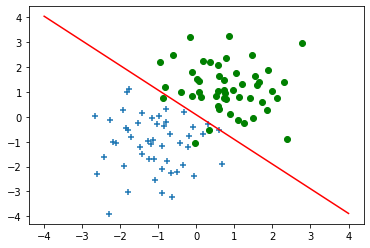

In [ ]:
fig = plt.figure()

x0_samples = data_0[:, [0, 1]]
x1_samples = data_1[:, [0, 1]]

plt.scatter(x0_samples[:,0],x0_samples[:,1], marker='+')
plt.scatter(x1_samples[:,0],x1_samples[:,1], c= 'green', marker='o')
plt.plot()
X_ = np.linspace(-4, 4, 100)
Y_ = - l1.w[0][0] /  l1.w[1][0] * X_ + (0.5 - l1.b[0][0]) / l1.w[1][0]
plt.plot(X_, Y_, '-r')

**Заменяем однослойную нейронную сеть двухслойной.**

Функцию обратного распространения ошибок необходимо переписать так, чтобы мы могли работать исключительно с матрицами, то есть в некоторых местах нужно поменять обычное умножение на матричное.

In [ ]:
class LayerM: # создаем класс 
    def __init__(self, n_inp, n_out, lr=0.01): # инициализируем необходимые параметры
        self.shape = (n_inp, n_out) # кол-во входных и выходных нейронов
        self.lr = lr
        self.w = np.zeros(self.shape, dtype=np.float32) # инициализируем вектор весов нулями
        self.b = np.zeros((1, n_out), dtype=np.float32) # инициализируем bias (смещение) нулем
        self._clear_grads()

    def _clear_grads(self): # функция очистки градиентов
        self.inp = None
        self.activations = None
        self.d_sigma = None
        self.d_w = None
        self.d_b = None

    def __call__(self, x): # функция прямого прохода
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        self.inp = x
        self.activations = sigmoid(x.dot(self.w) + self.b)
        return self.activations

    def backward(self, grad): # функция обратного прохода
        self.d_sigma = self.activations * (1 - self.activations)
        self.delta = grad * self.d_sigma
        self.d_w = self.inp.T @ self.delta
        self.d_b = self.delta * 1
        return np.sum(self.delta @ self.w.T)

    def grad_w(self, grad): # функции вычисления градиентов
        return grad * self.inp.T * self.d_sigma

    def grad_b(self, grad):
        return grad * self.d_sigma

    def grad_x(self, grad):
        return self.w.dot(grad) * self.d_sigma

    def step(self): # функция обновления весов
        self.w -= self.d_w * self.lr
        self.b -= self.d_b * self.lr
        self._clear_grads()

    def bin_result(self, act_out):
        if act_out < 0.5:
            return 0.0
        else:
            return 1.0

Реализация двухслойной сети - это более сложная задача. Подсказка: по сути мы можем отдельно пробрасывать градиент через каждый слой. Сделаем два слоя, например так:

lay_1 = Layer(2, 10)

lay_2 = Layer(10, 1)

И затем последовательно от второго слоя к первому передадим ошибку и сделаем шаг отдельно для второго слоя и отдельно для первого. 

In [ ]:
l1 = LayerM(2, 10)
l2 = LayerM(10, 1)
for i in range(5000):
    j = 0
    for x in X:
        y = l1(x)
        z = l2(y)
        d_z = diff_log_loss(z, T[j])
        b2 = l2.backward(d_z)
        l1.backward(b2)
        l2.step()
        l1.step()
        j += 1

In [ ]:
def two_layers_predict(inp, layers):
    layer1, layer2 = layers
    h = layer1(inp)
    y = layer2(h)
    return y

In [ ]:
predictions = []
for x in X:
    predictions.append(l1.bin_result(two_layers_predict(x, (l1, l2))))
print(accuracy_score(predictions, T))

0.95
